In [159]:
import pandas as pd
import numpy as np

# 데이터 불러오기 (경로 및 파일명에 맞게 수정)
df = pd.read_parquet('open/train/3.승인매출정보/201812_train_승인매출정보.parquet')

# 기준일 지정
reference_date = pd.to_datetime('2018-12-31')

# 최종이용일자_기본을 datetime 타입으로 변환 (오류 있으면 NaT)
df['최종이용일자_기본'] = pd.to_datetime(df['최종이용일자_기본'].astype(str), format='%Y%m%d', errors='coerce')

# Recency 계산 (기준일 - 최종이용일자)
df['Recency'] = (reference_date - df['최종이용일자_기본']).dt.days

# 음수 또는 결측인 Recency는 NaN 처리 후 제거
df.loc[df['Recency'] < 0, 'Recency'] = np.nan
df = df.dropna(subset=['Recency'])

In [161]:
# 음수는 0으로 대체
df.loc[df용_B0M'] < 0, ['이용건수_신'이용건수_신용_B0M'] = 0
df.loc[df['이용건수_일시불_B0M'] < 0, '이용건수_일시불_B0M'] = 0
df.loc[df['이용금액_일시불_B0M'] < 0, '이용금액_일시불_B0M'] = 0
df.loc[df['이용금액_할부_B0M'] < 0, '이용금액_할부_B0M'] = 0

# Frequency와 Monetary 합산
df['Frequency'] = df['이용건수_신용_B0M'] + df['이용건수_일시불_B0M']
df['Monetary'] = df['이용금액_일시불_B0M'] + df['이용금액_할부_B0M']

In [163]:
def assign_rfm_scores(df, q=5):
    # Recency 점수 (작을수록 좋으니 -를 붙여 qcut)
    recency_data = -df['Recency']
    recency_cat, recency_bins = pd.qcut(recency_data, q, retbins=True, duplicates='drop')
    recency_labels = list(range(len(recency_cat.cat.categories), 0, -1))  # 5~1
    df['R_score'] = pd.cut(recency_data, bins=recency_bins, labels=recency_labels, include_lowest=True)

    # Frequency 점수 (클수록 좋음)
    freq_data = df['Frequency']
    freq_cat, freq_bins = pd.qcut(freq_data, q, retbins=True, duplicates='drop')
    freq_labels = list(range(1, len(freq_cat.cat.categories) + 1))  # 1~5
    df['F_score'] = pd.cut(freq_data, bins=freq_bins, labels=freq_labels, include_lowest=True)

    # Monetary 점수 (클수록 좋음)
    mon_data = df['Monetary']
    mon_cat, mon_bins = pd.qcut(mon_data, q, retbins=True, duplicates='drop')
    mon_labels = list(range(1, len(mon_cat.cat.categories) + 1))  # 1~5
    df['M_score'] = pd.cut(mon_data, bins=mon_bins, labels=mon_labels, include_lowest=True)

    # 점수형을 정수형으로 변환 (nullable Int)
    df['R_score'] = df['R_score'].astype('Int64')
    df['F_score'] = df['F_score'].astype('Int64')
    df['M_score'] = df['M_score'].astype('Int64')

    return df

# 점수 할당 실행
df = assign_rfm_scores(df, q=5)

In [165]:
def classify_customer_loose(row):
    if pd.isna(row['R_score']) or pd.isna(row['F_score']) or pd.isna(row['M_score']):
        return 'Unknown'
    r, f, m = int(row['R_score']), int(row['F_score']), int(row['M_score'])
    
    # VIP: 3점 중 2개 이상이 4점 이상
    if sum([r >= 4, f >= 4, m >= 4]) >= 2:
        return 'VIP'
    # Loyal: 1개만 4점 이상
    elif sum([r >= 4, f >= 4, m >= 4]) == 1:
        return 'Loyal'
    # At Risk: 모두 1~2점
    elif r <= 2 and f <= 2 and m <= 2:
        return 'At Risk'
    else:
        return 'Regular'

# 고객군 분류 실행
df['Customer_Segment'] = df.apply(classify_customer_loose, axis=1)

In [167]:
# 샘플 데이터 확인
print(df[['Recency', 'Frequency', 'Monetary', 'R_score', 'F_score', 'M_score', 'Customer_Segment']].head())

# 고객군별 Recency, Frequency, Monetary 평균/중앙값 요약
profile_summary = df.groupby('Customer_Segment')[['Recency', 'Frequency', 'Monetary']].agg(['mean', 'median']).reset_index()
print(profile_summary)

# 고객군 분포 확인
print(df['Customer_Segment'].value_counts())

   Recency  Frequency  Monetary  R_score  F_score  M_score Customer_Segment
0      7.0         12      1079        1        2        1          At Risk
1     17.0         18      2439        2        2        2          At Risk
2      3.0         38      8373        1        3        4            Loyal
3     10.0         21      4930        2        3        3          Regular
4    117.0          0      3011        4        1        2            Loyal
  Customer_Segment     Recency          Frequency             Monetary  \
                          mean median        mean median          mean   
0          At Risk    7.248782    7.0    7.614411    6.0   1317.594041   
1            Loyal  175.253619   88.0   21.956751    0.0   2887.145726   
2          Regular   18.491769   19.0   18.688548   16.0   2902.064240   
3              VIP    7.830030    5.0  105.321709  101.0  13658.464710   

            
    median  
0   1232.0  
1    279.0  
2   3153.0  
3  12664.0  
Customer_Segment
Regu

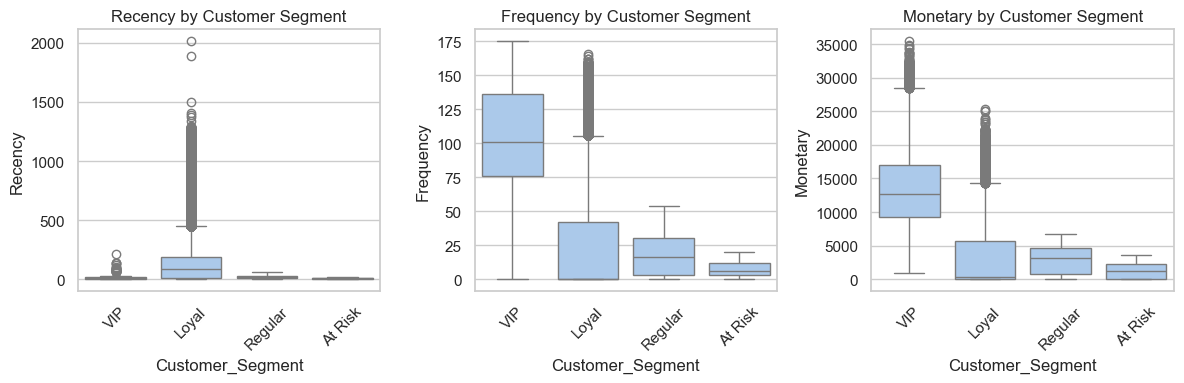

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns

order = ['VIP', 'Loyal', 'Regular', 'At Risk']

plt.figure(figsize=(12, 4))

for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='Customer_Segment', y=col, data=df, order=order)
    plt.title(f'{col} by Customer Segment')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

- VIP 고객은 높은 이용 빈도(Frequency)와 이용 금액(Monetary)을 기록하며, 충성도와 가치가 높은 핵심 고객층임을 확인하였다. 다만 Recency 값은 Loyal 고객에 비해 다소 높게 나타났는데, 이는 VIP 고객이 반드시 가장 최근에 거래한 고객이 아닐 수 있음을 의미한다. 즉, 과거 큰 거래를 기반으로 높은 가치를 유지하고 있으나, 최근 거래 빈도는 Loyal 고객보다 낮을 수 있음을 시사한다.
- Loyal 고객은 상대적으로 Recency 점수가 높아 최근 거래 빈도가 높은 고객군임을 알 수 있다. 다만, 이용 금액이나 빈도는 VIP 고객에 비해 다소 낮아, 향후 VIP 전환 가능성이 있는 충성 고객층으로 평가된다.
- Regular 고객은 평균적인 거래 빈도와 금액을 보이며, 안정적인 고객층으로 볼 수 있다. 이들은 추가적인 마케팅을 통해 충성도 제고가 가능한 대상이다.
- At Risk 고객은 최근성, 빈도, 금액 모두 낮아 이탈 가능성이 높은 고객군이다. 이들에 대해서는 이탈 방지 전략 및 재활성화 캠페인이 필요하다.

### 새로만든 Segment 별 주요 지표 요약

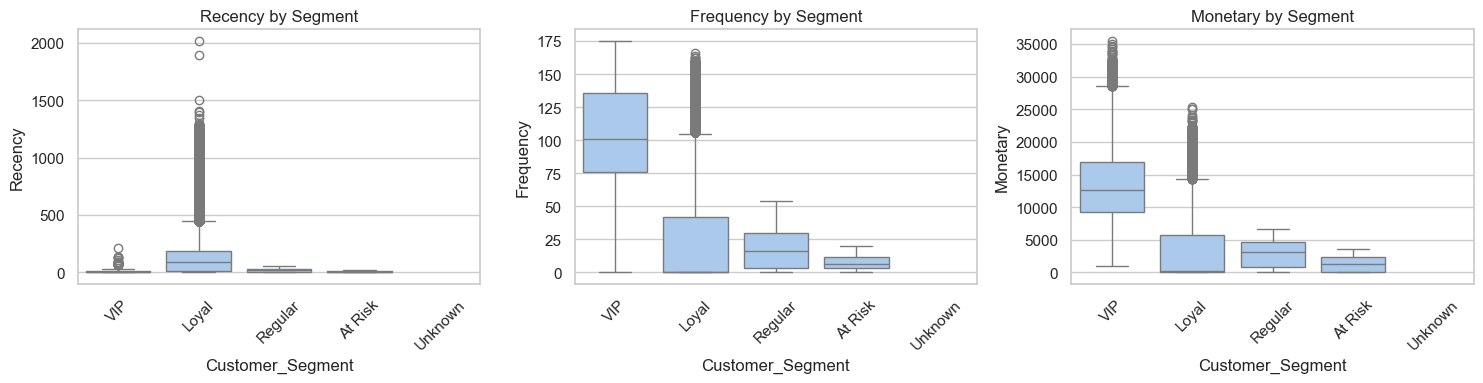

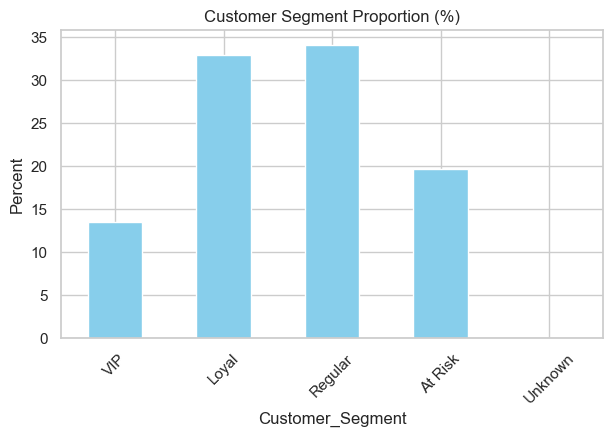

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns

# 박스플롯 시각화 (등급 순서 고정)
plt.figure(figsize=(15,4))
for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(data=df, x='Customer_Segment', y=col, 
                order=['VIP','Loyal','Regular','At Risk','Unknown'])
    plt.title(f'{col} by Segment')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 고객 비중 막대그래프 시각화 (안전하게 인덱스 재정렬 후 출력)
order = ['VIP','Loyal','Regular','At Risk','Unknown']
count_seg_ordered = count_seg.reindex(order).fillna(0)

plt.figure(figsize=(7,4))
count_seg_ordered.plot(kind='bar', color='skyblue')
plt.title('Customer Segment Proportion (%)')
plt.ylabel('Percent')
plt.xticks(rotation=45)
plt.show()

### 마케팅 우선순위 고객 추출
- VIP & Loyal 그룹 중 최근 90일 내 구매한 고객(Recency <= 90)
- 우선 연락/혜택 대상 리스트 생성 및 저장

In [192]:
target_customers = df[((df['Customer_Segment'].isin(['VIP','Loyal'])) & (df['Recency'] <= 90))]

print(f'우선 타겟 고객 수: {len(target_customers)}')

target_customers[['ID', 'Recency', 'Frequency', 'Monetary', 'Customer_Segment']].to_csv('priority_marketing_targets.csv', index=False)

print("우선순위 마케팅 대상 추출 파일 저장 완료: priority_marketing_targets.csv")

우선 타겟 고객 수: 116087
우선순위 마케팅 대상 추출 파일 저장 완료: priority_marketing_targets.csv
